2022-01-23 20:06:30,366 - strategy - DEBUG - Inicio funcion get_info_symbol...
2022-01-23 20:06:30,371 - strategy - DEBUG - Configuracion recuperada de archivo (conf_bybit_bot.json): {'symbol': 'BTCUSDT', 'pricePrecision': 5, 'quantityPrecision': 5}
124 - 2022-01-23_02:50:00, LONG CREATE, 35374.00
124 - 2022-01-23_02:50:00, BUY EXECUTED, Price: 35374.00, Cost: 95.06
152 - 2022-01-23_05:10:00, CLOSE LONG PROFIT 35534.500000
152 - 2022-01-23_05:10:00, SELL EXECUTED, Price: 35534.50, Cost: 95.06
152 - 2022-01-23_05:10:00, OPERATION PROFIT, GROSS 7.13, NET 7.38
152 - 2022-01-23_05:10:00, Balance: 100.43, gross_pnl: 7.13, self.buyprice: 35534.50, StopLoss: 35041.23, TakeProfit: 35873.15, risk_capital: -4.75, self.positionsize: 95.06, self.position_size: 504.79, quantity: 0.01, leverage: 6.00, net_pnl: 7.38, comision_open_position: -0.13, comision_close_position: -0.13
157 - 2022-01-23_05:35:00, LONG CREATE, 35680.00
157 - 2022-01-23_05:35:00, BUY EXECUTED, Price: 35680.00, Cost: 102.37
168 

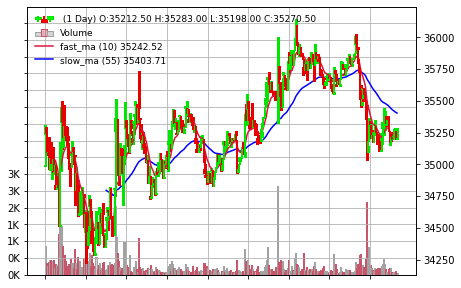

In [13]:
# Import the backtrader platform
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import pandas_ta as ta
import backtrader as bt
from backtrader.feeds import GenericCSVData
# import backtrader.plot
import brokers
from brokers.bybit_exchange import get_exchange, get_info_symbol
from scripts.indicators import get_atr, get_rsi, get_ema, get_sma, get_wma, get_hma2, get_hma3, get_hma2_prev_bar,get_hma3_prev_bar, Macd, Hma2, Hma3, Supertrend, get_supertrend, SSLChannel
from scripts.heikin_ashi import heikin_ashi


import datetime
import time  # For datetime objects
from time import strftime, gmtime
import pytz
import math
import os.path  # To manage paths
import sys  # To find out the script name (in argv[0])
import collections
projectPath = os.path.abspath(os.path.join(os.getcwd()))
sys.path.append(projectPath)


# import matplotlib
# import matplotlib.pyplot as plt
# from matplotlib.path import Path
# from matplotlib.patches import PathPatch
# matplotlib.use('Qt5Agg')
# plt.switch_backend('Qt5Agg')

# import backtrader.plot
# import matplotlib as plt
# matplotlib.use('agg')
# plt.switch_backend('agg')

# import IPython

# import backtrader.plot
# import matplotlib
# matplotlib.use('nbagg')


class CustomCSV(GenericCSVData):
    lines = ('hl2',)

    params = (
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('tmformat', '%H:%M:%S.%f'),
        ('datetime', 0),
        ('time', -1),
        ('high', 1),
        ('low', 2),
        ('open', 3),
        ('close', 4),
        ('volume', 5),
        ('hl2', 6),
        ('openinterest', -1),
    )

class PandasData(bt.feeds.PandasData):
    lines = ('hl2',)
    params = (
        ('dtformat', '%Y-%m-%d %H:%M:%S'),
        ('tmformat', '%H:%M:%S.%f'),
        ('datetime', None),
        ('time', -1),
        ('high', 'high'),
        ('low', 'low'),
        ('open', 'open'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('hl2', 'hl2'),
        ('openinterest', -1),
    )

# Create a Stratey
class TestStrategy(bt.Strategy):

    EXCHANGE_NAME = 'bybit'
    exchange = get_exchange()
    symbol = "BTCUSDT"
    timeframe = 5
    current_time_utc = datetime.datetime.now().timestamp()
    bar_number = 0
    info_symbol = ""

    entry_price = 0.0
    risk = 0.0
    risk_capital = 0.0
    StopLoss = 0.0
    TakeProfit = 0.0
    loss_capital = 0.0
    quantity = 0.0
    position_size = 0.0
    leverage = 0
    comision_maker = -0.025
    comision_taker =  0.075
    comision_open_position = 0.0
    comision_close_position = 0.0
    comisiones = 0.0
    total_gross_profit = 0.0
    total_gross_loss = 0.0
    profit_factor = 0.0
    balance = 0.0

    last_position = ""
    result_position = ""
    cant_position = 0
    cant_long_position = 0
    cant_short_position = 0
    cant_long_win_position = 0
    cant_long_loss_position = 0
    cant_short_win_position = 0
    cant_short_loss_position = 0
    efectividad_long = 0
    efectividad_short = 0
    efectividad = 0

    SL_ATRlen = 0.0
    sl_atr = 0.0
    reward_ratio = 0.0
    reward_ratio_new_target = 0.0

    contador_racha_perdedora = 0
    contador_posiciones_salteadas = 0
    stop_trade = False

    params = (
        ('fast_ma_period', 10),
        ('slow_ma_period', 55),
        ('ema_50_period', 150),
        ('ssl_period', 17),
        ('SL_ATRlen', 14),
        ('sl_atr', 8), #Se divide por 10 para obtener valor con decimales. Ej: 9 - 0.9
        ('reward_ratio', 15),  #Se divide por 10 para obtener valor con decimales. Ej: 13 - 1.3
        ('risk_perc', 5.0),
        ('cantidad_racha_perdedora', 0),
        ('cantidad_posiciones_saltear', 0),
        ('printlog', False),
        #('start_date', None),
        #('end_date', None),
        ('start_date', datetime.datetime.strptime('2021-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')),
        ('end_date', datetime.datetime.strptime('2022-12-31 23:59:00', '%Y-%m-%d %H:%M:%S')),
    )

    if info_symbol == "":
        info_symbol = get_info_symbol(exchange=exchange, symbol=symbol, info_symbol=info_symbol)

    def log(self, txt, dtime=None, doprint=True, printtime=True, tofile=False):
        ''' Logging function fot this strategy'''
        v_dtime = dtime or self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d_%H:%M:%S')
        if self.p.printlog or doprint:
            if printtime:
                print('%s - %s, %s' % (self.bar_number, v_dtime, txt))
                #time.sleep(0)
            else:
                print('%s' % (txt))
                #time.sleep(0)
        if tofile:
            with open("data/backtrader_strategy.csv", "a") as outfile:
                outfile.write(txt +'\n')

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.datadatetime = self.datas[0].datetime.datetime(0).strftime('%Y-%m-%d_%H:%M:%S')
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low
        self.dataopen = self.datas[0].open
        self.dataclose = self.datas[0].close
        self.datahl2 = self.datas[0].hl2
        self.sl_atr = float(self.p.sl_atr / 10)
        self.reward_ratio = float(self.p.reward_ratio / 10)
        self.balance = self.broker.getvalue()
        #print('Balance inicial: ', self.broker.getvalue())
        #print('Balance cash: ', self.broker.getcash())

        # To keep track of pending orders and buy price/commission
        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.inds = collections.defaultdict(dict)
        #self.spy = self.datas[0]
        self.stocks = self.datas[1:]

        for d in self.stocks:
            self.inds[d]['atr'] = bt.indicators.ATR(d, period=self.p.SL_ATRlen, plotname='atr', plotabove=False)

                # Add indicator
        self.fast_ma = bt.indicators.EMA(self.datas[0], period=self.p.fast_ma_period, plotname='fast_ma', plot=True)
        self.slow_ma = bt.indicators.EMA(self.datas[0], period=self.p.slow_ma_period, plotname='slow_ma', plot=True)
        #self.ema_50 = bt.indicators.EMA(self.datas[0], period=self.p.ema_50_period, plotname='ema_50')
        self.atr = bt.indicators.ATR(self.datas[0], period=self.p.SL_ATRlen, plotname='atr', plotabove=False, plot=False)

        #self.hma2 = Hma2(self.datas[0], plotname='hma2')
        #self.hma3 = Hma3(self.datas[0], plotname='hma3')
        #self.hullcrossover = bt.indicators.CrossOver(self.hma2, self.hma3, plot=False)
        #self.hullcrossunder = bt.indicators.CrossOver(self.hma3, self.hma2, plot=False)
        #self.ST_DF = get_supertrend(data=dataframe, length=10, multiplier=1)
        #print('Termino')
        #self.supertrend_1 = Supertrend(self.datas[0], period = 10, multiplier = 1, plotname='super_trend_1')
        #self.supertrend_2 = Supertrend(self.datas[0], period = 11, multiplier = 2, plotname='super_trend_2')
        #self.supertrend_3 = Supertrend(self.datas[0], period = 12, multiplier = 3, plotname='super_trend_3')
        self.ssl = SSLChannel(self.datas[0], period = self.p.ssl_period, plot=False)
        ## Set Conditions
        self.buyCond = bt.indicators.CrossUp(self.ssl.sslu, self.ssl.ssld, plot=False)
        self.sellCond = bt.indicators.CrossDown(self.ssl.sslu, self.ssl.ssld, plot=False)
        #self.ST_DF = get_supertrend(data=dataframe, length=10, multiplier=1)

    def within_range(self):
        date = self.data.datetime.datetime(0)
        if self.p.start_date is None and self.p.end_date is None:
            return True
        elif date >= self.p.start_date and date <= self.p.end_date:
            return True
        else:
            return False

    def notify_order(self, order):
    #     time.sleep(0)

    # def create_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed, order.Submitted, order.Accepted]:
            if order.isbuy():
                #self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Size: %.2f, Comm %.2f' %
                self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f' %
                    (order.executed.price,
                     order.executed.value))
                     #order.executed.size,
                     #order.executed.comm))

                #Se utiliza para exit Condition
                #if self.new_risk_perc > 0.0:
                #    self.risk_porcentaje = self.new_risk_perc
                #else:
                self.risk_porcentaje = self.p.risk_perc
                self.buyprice = order.executed.price
                self.positionsize = order.executed.value
                self.loss_capital = abs(self.positionsize * (self.risk_porcentaje / 100))
                self.comision_open_position = (self.position_size * self.comision_maker) / 100
                #print('Balance parcial: ', self.broker.getvalue())
                #print('Balance cash: ', self.broker.getcash())

            else:  # Sell
                #self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Size: %.2f, Comm %.2f' %
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f' %
                         (order.executed.price,
                          order.executed.value))
                          #order.executed.size,
                          #order.executed.comm))

                #Se utiliza para exit Condition
                #if self.new_risk_perc > 0.0:
                #    self.risk_porcentaje = self.new_risk_perc
                #else:
                self.risk_porcentaje = self.p.risk_perc

                self.buyprice = order.executed.price
                self.positionsize = order.executed.value
                self.loss_capital = abs(self.positionsize * (self.risk_porcentaje / 100))
                self.comision_open_position = (self.position_size * self.comision_maker) / 100
                #print('Balance parcial: ', self.broker.getvalue())
                #print('Balance cash: ', self.broker.getcash())

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # self.check_exit_position()

        # Write down: no pending order
        self.order = None

    # def notify_trade(self, trade):
    #     time.sleep(0)

    def notify_trade(self, trade):
    # def exit_trade(self):
        if not trade.isclosed:
            return

        # self.cant_position += 1

        if self.result_position == "win":
            gross_pnl = self.loss_capital * self.reward_ratio
            self.comision_close_position = ((self.quantity * self.TakeProfit) * self.comision_maker) / 100
            self.total_gross_profit += gross_pnl
            net_pnl = gross_pnl - self.comision_open_position - self.comision_close_position
            if self.p.cantidad_racha_perdedora > 0 and self.p.cantidad_posiciones_saltear > 0:
                self.contador_racha_perdedora = 0
        else:
            gross_pnl = -self.loss_capital
            #print('gross_pnl: ', gross_pnl)
            self.comision_close_position = ((self.quantity * self.StopLoss) * self.comision_taker) / 100
            self.total_gross_loss += gross_pnl
            net_pnl = gross_pnl - self.comision_open_position - self.comision_close_position
            if self.p.cantidad_racha_perdedora > 0 and self.p.cantidad_posiciones_saltear > 0:
                self.contador_racha_perdedora += 1

        #print('com_open: ', self.comision_open_position)
        #print('com_close: ',self.comision_close_position)

        self.comisiones += self.comision_open_position + self.comision_close_position
        #print('Comisiones: ', self.comisiones)
        #print('net_pnl: ', net_pnl)
        #print('Balance: ', self.broker.getvalue())
        #print('Cash: ', self.broker.getcash())
        self.broker.add_cash(net_pnl)
        #self.balance = self.broker.getvalue()# - self.comisiones

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
            (gross_pnl, net_pnl))
        self.log('Balance: %.2f, gross_pnl: %.2f, self.buyprice: %.2f, StopLoss: %.2f, TakeProfit: %.2f, risk_capital: %.2f, self.positionsize: %.2f, self.position_size: %.2f, quantity: %.2f, leverage: %.2f, net_pnl: %.2f, comision_open_position: %.2f, comision_close_position: %.2f'%
                         (self.broker.getvalue(), gross_pnl, self.buyprice, self.StopLoss, self.TakeProfit, -self.loss_capital, self.positionsize, self.position_size, self.quantity, self.leverage, net_pnl, self.comision_open_position, self.comision_close_position))




        # self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
        #          (trade.pnl, trade.pnlcomm))


    # def next(self):
    #     self.log('{} next, open {} close {}'.format(
    #         self.data.datetime.date(),
    #         self.data.open[0], self.data.close[0])
    #     )

    def check_exit_position(self):
        """check_exit_position"""

        #print('Open: ', self.dataopen[0])
        #print('ST1_down: ', self.supertrend_1.downTrend[0])
        #print('ST2_up: ', self.supertrend_2.upTrend[0])
        #print('ST1: ', self.supertrend_1[0])
        #print('ST2_down: ', self.supertrend_2.downTrend[0])

        if self.position:
            #print('self.buyCond[0]: ', self.buyCond[0])
            #print('self.sellCond[0]: ', self.sellCond[0])
            if self.last_position == "long":
                if self.datahigh[0] >= self.TakeProfit:
                #if self.dataopen[0] >= self.entry_price and self.supertrend_1.downTrend[0] and ((self.supertrend_2.upTrend[0] and self.dataopen[0] < self.supertrend_1[0]) or self.supertrend_2.downTrend[0]):
                #Se utiliza para el exitCondition
                #if self.dataopen[0] >= self.entry_price and self.sellCond[0]:
                    #self.log(f'CLOSE LONG PROFIT {self.dataclose[0]:2f}')
                    self.log(f'CLOSE LONG PROFIT {self.dataopen[0]:2f}')
                    self.result_position = "win"
                    self.cant_long_win_position += 1
                    ##Recalculo TP y SL para exit condition:
                    #self.exit_new_reward_ratio = (abs(self.entry_price - self.dataopen[0])) / (abs(self.entry_price - self.StopLoss ))
                    #self.TakeProfit = self.dataopen[0]
                    #self.TakeProfit = float("{:0.0{}f}".format(float(self.TakeProfit), self.info_symbol['pricePrecision']))
                    #self.reward_ratio = self.exit_new_reward_ratio
                    # self.exit_trade()
                    self.order = self.close()
                elif self.datalow[0] <= self.StopLoss:
                #Se utiliza para el exitCondition
                #elif self.datalow[0] <= self.StopLoss or (self.dataopen[0] < self.entry_price and self.sellCond[0]):
                    self.log(f'CLOSE LONG LOSS {self.dataopen[0]:2f}')
                    self.result_position = "loss"
                    self.cant_long_loss_position += 1
                    ## Recalculo perdida para exitCondition
                    #if self.datalow[0] > self.StopLoss:
                    #if self.dataopen[0] < self.entry_price and self.sellCond[0] == 1:
                    #    print('Recalculo perdida')
                    #    self.new_risk_perc = (((self.entry_price - self.dataopen[0]) * self.risk) / (self.entry_price - self.StopLoss)) * 100
                    #    self.loss_capital = abs(self.positionsize * (self.new_risk_perc / 100))
                    #    self.StopLoss = self.dataopen[0]
                        # self.exit_trade()
                    self.order = self.close()

            elif self.last_position == "short":
            #elif 1 == 0:
                if self.datalow[0] <= self.TakeProfit:
                #if self.dataopen[0] <= self.entry_price and self.supertrend_1.upTrend[0] and ((self.supertrend_2.downTrend[0] and self.dataopen[0] > self.supertrend_2[0]) or self.supertrend_2.upTrend[0]):
                #Se utiliza para el exitCondition
                #if self.dataopen[0] <= self.entry_price and self.buyCond[0]:
                    #self.log(f'CLOSE SHORT PROFIT {self.dataclose[0]:2f}')
                    self.log(f'CLOSE SHORT PROFIT {self.dataopen[0]:2f}')
                    self.result_position = "win"
                    self.cant_short_win_position += 1
                    ##Recalculo TP y SL para exitCondition:
                    #self.exit_new_reward_ratio = (abs(self.entry_price - self.dataopen[0])) / (abs(self.entry_price - self.StopLoss ))
                    #self.TakeProfit = self.dataopen[0]
                    #self.TakeProfit = float("{:0.0{}f}".format(float(self.TakeProfit), self.info_symbol['pricePrecision']))
                    #self.reward_ratio = self.exit_new_reward_ratio
                    # self.exit_trade()
                    self.order = self.close()
                elif self.datahigh[0] >= self.StopLoss:
                #elif self.dataopen[0] > self.entry_price and self.supertrend_1.upTrend[-1] and self.supertrend_2.upTrend[-1]:
                #Se utiliza para el exitCondition
                #elif self.datahigh[0] >= self.StopLoss or (self.dataopen[0] > self.entry_price and self.buyCond[0]):
                    #self.log(f'CLOSE SHORT LOSS {self.dataclose[0]:2f}')
                    self.log(f'CLOSE SHORT LOSS {self.dataopen[0]:2f}')
                    self.result_position = "loss"
                    self.cant_short_loss_position += 1
                    ## Recalculo perdida para exitCondition
                    #if self.dataopen[0] > self.entry_price and self.buyCond[0] == 1:
                    #    print('Recalculo perdida')
                    #    self.new_risk_perc = (((self.dataopen[0] - self.entry_price) * self.risk) / (self.StopLoss - self.entry_price)) * 100
                    #    self.loss_capital = abs(self.positionsize * (self.new_risk_perc / 100))
                    #    self.StopLoss = self.dataopen[0]
                    # self.exit_trade()
                    self.order = self.close()

    def create_long_position(self):
        # Check if we are in the market
        # LONG
        self.entry_price = self.dataopen[0]
        #print('EP: ', self.entry_price)
        balance_details_size = self.broker.getvalue() * 0.95
        #print('Balance Parcial: ', self.broker.getvalue())

        SL_ret = self.entry_price - (self.atr[-1] * self.sl_atr)
        self.StopLoss = float("{:0.0{}f}".format(float(min(SL_ret, self.datalow[-1] - (self.atr[-1] * 0.2))), self.info_symbol['pricePrecision']))
        TakeProfit_tmp = self.entry_price + (abs(self.entry_price - self.StopLoss) * self.reward_ratio)
        #print('self.StopLoss: ', self.StopLoss)
        #print('self.entry_price: ', self.entry_price)
        #print('self.reward_ratio: ', self.reward_ratio)
        #print('self.entry_price + (abs(self.entry_price - self.StopLoss) * self.reward_ratio): ', self.entry_price + (abs(self.entry_price - self.StopLoss) * self.reward_ratio))

        self.TakeProfit = float("{:0.0{}f}".format(float(TakeProfit_tmp), self.info_symbol['pricePrecision']))
        self.risk = self.p.risk_perc / 100
        self.risk_capital = self.risk * balance_details_size
        self.quantity = float("{:0.0{}f}".format(float(self.risk_capital / abs(self.entry_price - self.StopLoss)), self.info_symbol['quantityPrecision']))
        self.position_size = self.quantity * self.entry_price
        self.leverage = math.ceil(self.position_size / balance_details_size)
        # BUY, BUY, BUY!!! (with all possible default parameters)
        self.log('LONG CREATE, %.2f' % self.entry_price)
        #print('TP: ', self.TakeProfit)
        #print('SL: ', self.StopLoss)
        # self.broker.setcommission(commission=0.1, margin=2000, mult=self.leverage
        # Keep track of the created order to avoid a 2nd order
        # self.order = self.buy(exectype=bt.Order.Limit, price=self.entry_price, size=self.position_size)
        self.order = self.buy(exectype=bt.Order.Limit, price=self.entry_price)
        self.last_position = "long"
        # self.create_order(self.order)

    def create_short_position(self):
        #self.entry_price = self.dataopen[-1]
        self.entry_price = self.dataopen[0]
        balance_details_size = self.broker.getvalue() * 0.95
        SL_ret = self.entry_price + (self.atr[-1] * self.sl_atr)
        self.StopLoss = float("{:0.0{}f}".format(float(max(SL_ret, self.datahigh[-1] + (self.atr[-1] * 0.2))), self.info_symbol['pricePrecision']))
        self.TakeProfit = self.entry_price - (abs(self.entry_price - self.StopLoss) * self.reward_ratio)
        self.TakeProfit = float("{:0.0{}f}".format(float(self.TakeProfit), self.info_symbol['pricePrecision']))
        self.risk = self.p.risk_perc / 100
        self.risk_capital = self.risk * balance_details_size
        self.quantity = float("{:0.0{}f}".format(float(self.risk_capital / abs(self.entry_price - self.StopLoss)), self.info_symbol['quantityPrecision']))
        self.position_size = self.quantity * self.entry_price
        self.leverage = math.ceil(self.position_size / balance_details_size)
        self.log('SHORT CREATE, %.2f' % self.entry_price)
        #    Keep track of the created order to avoid a 2nd order
        self.order = self.sell(exectype=bt.Order.Limit, price=self.entry_price)
        self.last_position = "short"
        # self.create_order(self.order)


    def check_to_create_position(self):

        if not self.within_range():
            return

    # Check if we are in the market
        if not self.position:
            #self.reward_ratio = float(self.p.reward_ratio / 10)
            #self.new_risk_perc = 0.0
            # LONG
            #if self.buyCond[0] and self.dataopen[0] > self.ema_50[0] and self.stop_trade is False:
            if self.buyCond[0] and self.fast_ma[0] > self.slow_ma[0] and self.stop_trade is False:
                self.create_long_position()
            #elif self.buyCond[0] and self.dataopen[0] > self.ema_50[0] and self.stop_trade is True:
            #elif self.buyCond[0] and self.dataopen[0] > self.ema_50[0] and self.stop_trade is True:
            elif self.buyCond[0] and self.fast_ma[0] > self.slow_ma[0] and self.stop_trade is True:
                print('Salteo posicion Open price: ', self.dataopen[0])
                self.contador_posiciones_salteadas += 1

            #if self.sellCond[0] and self.dataopen[0] < self.ema_50[0] and self.stop_trade is False:
            if self.sellCond[0] and self.fast_ma[0] < self.slow_ma[0] and self.stop_trade is False:
                self.create_short_position()
            #elif self.sellCond[0] and self.dataopen[0] < self.ema_50[0] and self.stop_trade is True:
            elif self.sellCond[0] and self.fast_ma[0] < self.slow_ma[0] and self.stop_trade is True:
                print('Salteo posicion Open price: ', self.dataopen[0])
                self.contador_posiciones_salteadas += 1


            #if self.supertrend_1.upTrend[0] and self.supertrend_2.upTrend[0] and self.supertrend_3.upTrend[0] and self.dataopen[0] > self.ema_50[0]:
            #if self.hullcrossunder[0] > 0 and self.fast_ma[0] >= self.slow_ma[0]: # Fast ma crosses above slow ma
                #self.entry_price = self.dataopen[0]
                #balance_details_size = self.broker.getvalue() * 0.95
                #SL_ret = self.entry_price - (self.atr[-1] * self.sl_atr)
                #self.StopLoss = float("{:0.0{}f}".format(float(min(SL_ret, self.datalow[-1] - (self.atr[-1] * 0.2))), self.info_symbol['pricePrecision']))
                #self.TakeProfit = self.entry_price + (abs(self.entry_price - self.StopLoss) * self.reward_ratio)
                #self.TakeProfit = float("{:0.0{}f}".format(float(self.TakeProfit), self.info_symbol['pricePrecision']))
                #self.risk = self.p.risk_perc / 100
                #self.risk_capital = self.risk * balance_details_size
                #self.quantity = float("{:0.0{}f}".format(float(self.risk_capital / abs(self.entry_price - self.StopLoss)), self.info_symbol['quantityPrecision']))
                #self.position_size = self.quantity * self.entry_price
                #self.leverage = math.ceil(self.position_size / balance_details_size)

                # BUY, BUY, BUY!!! (with all possible default parameters)
                #self.log('LONG CREATE, %.2f' % self.entry_price)

                # self.broker.setcommission(commission=0.1, margin=2000, mult=self.leverage)

                # Keep track of the created order to avoid a 2nd order
                # self.order = self.buy(exectype=bt.Order.Limit, price=self.entry_price, size=self.position_size)
                #self.order = self.buy(exectype=bt.Order.Limit, price=self.entry_price)
                #self.last_position = "long"
                # self.create_order(self.order)

            # SHORT
            #elif self.supertrend_1.downTrend[-1] and self.supertrend_2.downTrend[-1] and self.supertrend_3.downTrend[-1] and self.dataopen[0] < self.ema_50[0]:
            #elif 1 == 0:
            #elif self.hullcrossover[0] > 0 and self.fast_ma[0] < self.slow_ma[0]:
                # SELL, SELL, SELL!!! (with all possible default parameters)

                #self.entry_price = self.dataopen[-1]
                #balance_details_size = self.broker.getvalue() * 0.95
                #SL_ret = self.entry_price + (self.atr[-1] * self.sl_atr)
                #self.StopLoss = float("{:0.0{}f}".format(float(max(SL_ret, self.datahigh[-1] + (self.atr[-1] * 0.2))), self.info_symbol['pricePrecision']))
                #self.TakeProfit = self.entry_price - (abs(self.entry_price - self.StopLoss) * self.reward_ratio)
                #self.TakeProfit = float("{:0.0{}f}".format(float(self.TakeProfit), self.info_symbol['pricePrecision']))
#
                #self.risk = self.p.risk_perc / 100
                #self.risk_capital = self.risk * balance_details_size
                #self.quantity = float("{:0.0{}f}".format(float(self.risk_capital / abs(self.entry_price - self.StopLoss)), self.info_symbol['quantityPrecision']))
                #self.position_size = self.quantity * self.entry_price
                #self.leverage = math.ceil(self.position_size / balance_details_size)
#
                #self.log('SHORT CREATE, %.2f' % self.entry_price)
#
                ## Keep track of the created order to avoid a 2nd order
                #self.order = self.sell(exectype=bt.Order.Limit, price=self.entry_price)
                #self.last_position = "short"
                ## self.create_order(self.order)

    def next(self):
        # self.log('Next %0.2f, %0.2f, %0.2f, %0.2f' % (
        #     self.data.open[0], self.data.high[0], self.data.low[0],
        #     self.data.close[0]))
        time.sleep(0)
        #self.log('NEXT: High: %.2f - Low: %.2f - Open: %.2f - Close: %.2f - HL2: %.2f - ATR: %.10f - ST1: %.2f - ST1_UP: %f - ST2_UP: %f' % (self.datahigh[0], self.datalow[0], self.dataopen[0], self.dataclose[0], self.datahl2[0], self.atr[0], self.supertrend_1[0], self.supertrend_1.upTrend[0], self.supertrend_2.upTrend[0]), doprint=True)
        #self.log('NEXT:High: %.2f - Low: %.2f - Open: %.2f - Close: %.2f - HL2: %.2f - ATR: %.10f - buyCond: %.2f - sellCond: %.2f - sslu: %f - ssld: %f' % (self.datahigh[0], self.datalow[0], self.dataopen[0], self.dataclose[0], self.datahl2[0], self.atr[0], self.buyCond[0], self.sellCond[0], self.ssl.sslu[0], self.ssl.ssld[0]), doprint=True)
        #self.log('NEXT: Open: %.2f - Close: %.2f - buyCond: %.2f - sellCond: %.2f - sslu: %f - ssld: %f' % (self.dataopen[0], self.dataclose[0], self.buyCond[0], self.sellCond[0], self.ssl.sslu[0], self.ssl.ssld[0]), doprint=True)
        # self.check_exit_position()


    def next_open(self):
    # def next(self):
        # Simply log the closing price of the series from the reference
        #self.log('High: %.2f - Low: %.2f - Open: %.2f - Close: %.2f - HL2: %.2f ATR: %.10f - fast_ma: %.2f - slow_ma: %.2f - CrossFastOverSlow: %s - HMA2: %.2f - HMA3: %.2f - self.hullcrossover: %s' % (self.datahigh[0], self.datalow[0], self.dataopen[0], self.dataclose[0], self.datahl2[0], self.atr[0], self.fast_ma[0], self.slow_ma[0], self.fast_ma[0] >= self.slow_ma[0], self.hma2[0], self.hma3[0], self.hullcrossover[0] > 0), doprint=True)
        #self.log('NEXT-OPEN: High: %.2f - Low: %.2f - Open: %.2f - Close: %.2f - HL2: %.2f - ATR: %.10f - ST1: %.2f - ST1_UP: %f - ST2_UP: %f' % (self.datahigh[0], self.datalow[0], self.dataopen[0], self.dataclose[0], self.datahl2[0], self.atr[0], self.supertrend_1[0], self.supertrend_1.upTrend[0], self.supertrend_2.upTrend[0]), doprint=True)
        #self.log('NEXT-OPEN: High: %.2f - Low: %.2f - Open: %.2f - Close: %.2f - HL2: %.2f - ATR: %.10f - buyCond: %.2f - sellCond: %.2f - sslu: %f - ssld: %f' % (self.datahigh[0], self.datalow[0], self.dataopen[0], self.dataclose[0], self.datahl2[0], self.atr[0], self.buyCond[0], self.sellCond[0], self.ssl.sslu[0], self.ssl.ssld[0]), doprint=True)


        # self.log('Next Open %0.2f, %0.2f, %0.2f, %0.2f' % (
        #     self.data.open[0], self.data.high[0], self.data.low[0],
        #     self.data.close[0]))
        # self.check_exit_position()
        self.bar_number += 1

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return


        if self.p.cantidad_racha_perdedora == 0 and self.p.cantidad_posiciones_saltear == 0:
            self.stop_trade = False
            self.contador_posiciones_salteadas = 0
            self.contador_racha_perdedora = 0
        else:
            if self.contador_racha_perdedora == self.p.cantidad_racha_perdedora:
                self.stop_trade = True

            if self.contador_posiciones_salteadas >= self.p.cantidad_posiciones_saltear and self.stop_trade is True:
                self.stop_trade = False
                self.contador_posiciones_salteadas = 0
                self.contador_racha_perdedora = 0

        self.check_to_create_position()
        self.check_exit_position()


    def stop(self):
        self.cant_long_position = self.cant_long_win_position + self.cant_long_loss_position
        self.cant_short_position = self.cant_short_win_position + self.cant_short_loss_position
        self.cant_position = self.cant_long_position + self.cant_short_position
        if self.cant_long_position != 0:
            self.efectividad_long = int((self.cant_long_win_position / self.cant_long_position) * 100)
        if self.cant_short_position != 0:
            self.efectividad_short = int((self.cant_short_win_position / self.cant_short_position) * 100)
        if self.cant_position != 0:
            self.efectividad = int(((self.cant_long_win_position + self.cant_short_win_position) / self.cant_position) * 100)

        if self.total_gross_loss != 0:
            self.profit_factor = abs(self.total_gross_profit / self.total_gross_loss)
        else:
            self.profit_factor = 1.0

        # Filtro de impresion en pantalla
        #if self.broker.getvalue() > 100 and self.efectividad >= 55 and self.efectividad_long >= 50 and self.efectividad_short >= 50:
        #if self.broker.getvalue() > 250:
        if 1 == 1:
            #balance_final = self.broker.getvalue() - self.comisiones
            #self.log('fast_ma: %2d , slow_ma: %2d , SL_ARTlen: %2d , sl_atr: %.1f , reward_ratio: %.1f , Positions: %d , Pos Long: %d, Pos Short: %d, Efectividad: %d , Long: %d , Short: %d , Balance: %.2f , Comisiones: %.2f , Profit_Factor: %.2f' %
            self.log('-----------------------------------------------------------', doprint=True, printtime=False, tofile=True)
            self.log('ema_50_period: %2d \nssl_period: %2d \nSL_ARTlen: %2d \nsl_atr: %.1f \nPositions: %d \nPos Long: %d \nPos Short: %d \nEfectividad: %d %% \nLong: %d %% \nShort: %d %% \nBalance: %.2f USDT \nComisiones: %.2f USDT \nProfit_Factor: %.2f' %
                 (self.p.ema_50_period, self.p.ssl_period, self.p.SL_ATRlen, self.sl_atr, self.cant_position, self.cant_long_position, self.cant_short_position, self.efectividad, self.efectividad_long, self.efectividad_short, self.broker.getvalue(), self.comisiones, self.profit_factor), doprint=True, printtime=False, tofile=True)
            self.log('-----------------------------------------------------------', doprint=True, printtime=False, tofile=True)

# define custom commission scheme that reproduces Binance perpetual future trading
class CommInfo_BinancePerp(bt.CommInfoBase):
    params = (
      ('stocklike', False),  # Futures
      ('commtype', bt.CommInfoBase.COMM_PERC),  # Apply % Commission
    )

    def _getcommission(self, size, price, pseudoexec):
        return size * price * self.p.commission * self.p.mult

    def get_margin(self, price):
        return price / self.p.mult

    def getsize(self, price, cash):
        '''Returns fractional size for cash operation @price'''
        return self.p.mult * (cash / price)

class CryptoContractCommissionInfo(bt.CommissionInfo):
    '''Commission scheme for cryptocurrency contracts.
        Including futures contracts and perpetual swap contracts.
        Required Args:
            commission: commission fee in percentage, between 0.0 and 1.0
            mult: leverage, for example 10 means 10x leverage
    '''
    params = (
        ('stocklike', False),
        ('commtype', bt.CommInfoBase.COMM_PERC), # apply % commission
    )

    def __init__(self):
        assert abs(self.p.commission) < 1.0 # commission is a percentage
        assert self.p.mult >= 1.0
        assert self.p.margin is None
        assert self.p.commtype == bt.CommInfoBase.COMM_PERC
        assert not self.p.stocklike
        assert self.p.percabs
        assert self.p.leverage == 1.0
        self.p.automargin = 1 / self.p.mult

        super().__init__()

    def getsize(self, price, cash):
        '''Support fractional size.

            More details at https://www.backtrader.com/blog/posts/2019-08-29-fractional-sizes/fractional-sizes/.
        '''
        # return self.p.leverage * (cash / price)
        return self.p.mult * (cash / price)

    def _getcommission(self, size, price, pseudoexec):
        '''Percentage based commission fee.

            More details at https://www.backtrader.com/docu/user-defined-commissions/commission-schemes-subclassing/.
        '''
        return abs(size) * self.p.commission * price * self.p.mult


if __name__ == '__main__':

    df = pd.DataFrame(columns=['symbol', 'fast_ma', 'slow_ma', 'SL_ARTlen', 'sl_atr', 'reward_ratio', 'positions', 'win', 'loss', 'efectividad', 'balance'])

    # Create a cerebro entity
    cerebro = bt.Cerebro(cheat_on_open=True)

    ##Add a strategy
    #strats = cerebro.optstrategy(
    #    TestStrategy,
    #    #fast_ma_period=range(8, 27),
    #    #slow_ma_period=range(34, 61),
    #    ema_50_period=range(50, 101),
    #    ssl_period=range(20, 28),
    #    SL_ATRlen=range(8, 17),
    #    sl_atr=range(8, 14),
    #    #reward_ratio=range(13, 15),
    #    )

    cerebro.addstrategy(TestStrategy)

    # Datas are in a subfolder of the samples. Need to find where the script is
    # because it could have been called from anywhere
    # modpath = os.path.dirname(os.path.abspath(sys.argv[0]))
    # datapath = os.path.join(modpath, 'data/2021_3minutes.csv')
    # datapath = ('data/2021_3minutes.csv')
    # datapath = ('data/2021_3minutes_v2_prod.csv')
    # datapath = ('data/2021_15minutes_v2_testnet.csv')
    # datapath = ('data/2021_15minutes_v2_prod.csv')
    datapath = ('data/BTCUSDT_2022_5minutes_prod.csv')

    # Create a Data Feed
    fromdate = datetime.datetime.strptime('2021-01-01', '%Y-%m-%d')
    todate = datetime.datetime.strptime('2022-12-31', '%Y-%m-%d')
    # data = CustomCSV(dataname='data/2021_3minutes.csv', dtformat=('%Y-%m-%d %H:%M:%S'), timeframe=bt.TimeFrame.Minutes)
    # data = CustomCSV(dataname='data/2021_3minutes_v2_prod.csv', dtformat=('%Y-%m-%d %H:%M:%S'), timeframe=bt.TimeFrame.Minutes)
    # data = CustomCSV(dataname='data/2021_15minutes_v2_testnet.csv', dtformat=('%Y-%m-%d %H:%M:%S'), timeframe=bt.TimeFrame.Minutes)
    # data = CustomCSV(dataname='data/2021_15minutes_v2_prod.csv', dtformat=('%Y-%m-%d %H:%M:%S'), timeframe=bt.TimeFrame.Minutes)
    # data = CustomCSV(dataname='data/2021_3minutes_testnet.csv', dtformat=('%Y-%m-%d %H:%M:%S'), timeframe=bt.TimeFrame.Minutes)
    dataframe = pd.read_csv(datapath,
                                skiprows=0,
                                header=0,
                                parse_dates=True,
                                index_col='datetime')

    # print(dataframe)
    # data = bt.feeds.PandasData(dataname=dataframe, openinterest=-1)
    # data3 = bt.feeds.PandasData(dataname=dataframe, tz=pytz.timezone('America/Argentina/Buenos_Aires'))
    # data2 = PandasData(dataname=dataframe, tz=pytz.timezone('America/Argentina/Buenos_Aires'))
    data2 = PandasData(dataname=dataframe)
    # print(dataframe)

    # column_order_names = ["datetime", "high", "low", "open", "close", "volume"]
    # df = df.reindex(columns=column_order_names)
    heikin_ashi_df = heikin_ashi(dataframe)
    # print(heikin_ashi_df)
    data3 = PandasData(dataname=heikin_ashi_df, tz=pytz.timezone('America/Argentina/Buenos_Aires'))

    # Add the Data Feed to Cerebro
    cerebro.adddata(data2)

    # Set our desired cash start
    cerebro.broker.setcash(100.0)
    # cerebro.broker.set_shortcash(True)

    # Add a FixedSize sizer according to the stake
    cerebro.addsizer(bt.sizers.PercentSizer, percents=95)

    # Set the commission
    #cerebro.broker.setcommission(commission=0.00)

    # comminfo = CommInfo_BinancePerp(commission=0.00025, mult=binance_leverage, automargin=True)
    #comminfo = CryptoContractCommissionInfo(commission=0.0, mult=1)
    #cerebro.broker.addcommissioninfo(comminfo)

    # Run over everything
    # cerebro.run(maxcpus=1)
    #cerebro.run(maxcpus=None, preload=True, runonce=True, optreturn=True, optdatas=True, stdstats = False)
    cerebro.run(preload=True, runonce=True, optreturn=True, optdatas=True, stdstats = False)

    # %matplotlib inline
    # cerebro.plot()
    # cerebro.plot(iplot= True)
    plt.rcParams['font.sans-serif']=['SimHei']
    plt.rcParams['axes.unicode_minus']=False
    plt.rcParams['figure.figsize']=[18, 16]
    plt.rcParams['figure.dpi']=200
    plt.rcParams['figure.facecolor']='w'
    plt.rcParams['figure.edgecolor']='k'
    cerebro.plot(style='candle', numfigs=1, barup ='lime', bardown ='red', valuetags=False, iplot=False)
    # cerebro.plot(height = 30, iplot = False)
    # plt.show()
